#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name, images=None, labels=None):
        self.name = name
        self.is_loaded = False

        if images is None:
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(f'{name}.npz')
            #np_obj = np.load(f'/content/drive/MyDrive/khv/{name}.npz')

        self.images = np_obj['data']   if images is None else images
        self.labels = np_obj['labels'] if labels is None else labels
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def __len__(self):
        return len(self.images)

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Обёртка над Dataset для использования с PyTorch

In [6]:
import torchvision.transforms as T

In [7]:
#LBL11
class Augmentations:
    def __init__(self):
        self.train_transform = T.Compose([
            T.ToPILImage(),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            #T.RandomRotation(degrees=45),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, img, mode='train'):
        if mode == 'train':
            return self.train_transform(img)
        return self.test_transform(img)

In [8]:
import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
from PIL import Image

class HistologyTorchDataset(TorchDataset):
    """
    Обёртка над Dataset для использования с PyTorch.
    """
    def __init__(self, dataset=None, images=None, labels=None, mode='test'):
        if dataset is None:
            self.base = Dataset('', images, labels)
        else:
            self.base = dataset
        self.augmentations = Augmentations()
        self.mode = mode

    @property
    def images(self):
        return self.base.images

    @property
    def labels(self):
        return self.base.labels

    def __len__(self):
        return len(self.base.images)

    def __getitem__(self, idx):
        """
        Возвращает (image_tensor, label) для PyTorch.
        image_tensor: torch.Tensor формы [3, H, W]
        label: int
        """
        img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
        img_tensor = self.augmentations(img, mode=self.mode)
        return img_tensor, label

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [10]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 9)
        )

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def save(self, name: str):
        path = f'/content/drive/MyDrive/khv/{name}.pth'
        torch.save({
            'model_state_dict': self.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
        }, path)
        print(f'Model saved')

    def load(self, name: str):
        #path = f'/content/drive/MyDrive/khv/{name}.pth'
        #checkpoint = torch.load(path, map_location=self.device)
        name_to_id_dict = {
            'best_4_10_94': '1VBtyuX2bxqkjYazn4XZFMnnA_LgAzG3_',
            'best_4_11_95': '1mkcuXL7sVLBV7URUD2qnxLLmuzCZNYMi',
            'best_4_20_96': '1sNa1g2OehbFTSD4WlmYiWLpZYa9Z74fh',
            'best_4_24_96': '1vo80z8rJ6jvidxx26M9faCv8GAQoVkg0',
            'best':         '1sNa1g2OehbFTSD4WlmYiWLpZYa9Z74fh'
        }
        output = f'{name}.npz'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        checkpoint = torch.load(f'{name}.npz', map_location=self.device)

        self.load_state_dict(checkpoint['model_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.train_accuracies = checkpoint['train_accuracies']
        self.val_accuracies = checkpoint['val_accuracies']

        print(f'Model loaded')

    def train_model(self, dataset, epochs: int, batch_size: int, val_split: float):
        # Train/val split
        all_indices = np.arange(len(dataset))
        train_indices, val_indices = train_test_split(
            all_indices,
            test_size=val_split,
            random_state=42,
            stratify=dataset.labels
        )

        train_images = dataset.images[train_indices]
        train_labels = dataset.labels[train_indices]
        val_images = dataset.images[val_indices]
        val_labels = dataset.labels[val_indices]

        train_dataset = HistologyTorchDataset(images=train_images, labels=train_labels, mode='train')
        val_dataset   = HistologyTorchDataset(images=val_images,   labels=val_labels,   mode='test')

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(epochs):
            # Training
            self.train()

            train_loss = 0
            correct = 0
            total = 0

            train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for batch_idx, (x, y_gt) in enumerate(train_bar):
                x, y_gt = x.to(self.device), y_gt.to(self.device)

                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y_gt)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                _, pred = pred.max(1)
                total += y_gt.size(0)
                correct += pred.eq(y_gt).sum().item()

                train_bar.set_postfix({
                    'Loss': f'{train_loss/(batch_idx+1):.3f}',
                    'Acc': f'{100*correct/total:.2f}%'
                })

            train_loss /= len(train_loader)
            train_acc = 100 * correct / total

            #LBL1
            # Validation
            self.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for x, y_gt in val_loader:
                    x, y_gt = x.to(self.device), y_gt.to(self.device)
                    pred = self(x)
                    loss = criterion(pred, y_gt)
                    val_loss += loss.item()

                    _, pred = pred.max(1)
                    total += y_gt.size(0)
                    correct += pred.eq(y_gt).sum().item()

            val_loss /= len(val_loader)
            val_acc = 100 * correct / total

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            scheduler.step()

            #LBL5
            print(f'\nEpoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            #LBL3
            if val_acc == max(self.val_accuracies):
                self.save(f'best_4_{epoch}_{int(val_acc)}')
                print('  >>> Model saved')

        print('Training completed')

    def plot_training_history(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.val_accuracies, label='Val Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test_on_dataset(self, dataset, limit=None):
        self.eval()
        predictions = []

        n = len(dataset) if not limit else int(len(dataset) * limit)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        with torch.no_grad():
            for batch in tqdm(dataloader, total=min(len(dataloader), n // 32)):
                if len(predictions) >= n:
                    break

                x = batch[0]

                x = x.to(self.device)
                pred = self(x)
                _, batch_preds = pred.max(1)
                predictions.extend(batch_preds.cpu().numpy())

        return predictions[:n]

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [12]:
d_train = HistologyTorchDataset(Dataset('train'), mode='train')
d_test = HistologyTorchDataset(Dataset('test'), mode='test')

Done. Dataset train consists of 18000 images.
Done. Dataset test consists of 4500 images.


In [13]:
model = Model()
if not EVALUATE_ONLY:
    model.train_model(d_train, epochs=30, batch_size=64, val_split=0.1)
    model.save('best')
else:
    model.load('best')

Done. Dataset  consists of 16200 images.
Done. Dataset  consists of 1800 images.


Epoch 1/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 1/30:
  Train Loss: 1.1127, Train Acc: 59.58%
  Val Loss: 0.8466, Val Acc: 70.06%
Model saved
  >>> Model saved


Epoch 2/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 2/30:
  Train Loss: 0.7427, Train Acc: 73.07%
  Val Loss: 0.7105, Val Acc: 75.44%
Model saved
  >>> Model saved


Epoch 3/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 3/30:
  Train Loss: 0.5086, Train Acc: 82.59%
  Val Loss: 2.6872, Val Acc: 52.44%


Epoch 4/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 4/30:
  Train Loss: 0.3860, Train Acc: 86.86%
  Val Loss: 0.2803, Val Acc: 90.67%
Model saved
  >>> Model saved


Epoch 5/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 5/30:
  Train Loss: 0.3242, Train Acc: 89.07%
  Val Loss: 0.2607, Val Acc: 91.28%
Model saved
  >>> Model saved


Epoch 6/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 6/30:
  Train Loss: 0.2874, Train Acc: 90.44%
  Val Loss: 0.3218, Val Acc: 90.06%


Epoch 7/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 7/30:
  Train Loss: 0.2694, Train Acc: 91.09%
  Val Loss: 0.2094, Val Acc: 92.83%
Model saved
  >>> Model saved


Epoch 8/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 8/30:
  Train Loss: 0.2439, Train Acc: 91.88%
  Val Loss: 0.2617, Val Acc: 91.61%


Epoch 9/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 9/30:
  Train Loss: 0.2294, Train Acc: 92.37%
  Val Loss: 0.2318, Val Acc: 92.83%
Model saved
  >>> Model saved


Epoch 10/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 10/30:
  Train Loss: 0.2277, Train Acc: 92.50%
  Val Loss: 0.2255, Val Acc: 93.00%
Model saved
  >>> Model saved


Epoch 11/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 11/30:
  Train Loss: 0.1723, Train Acc: 94.35%
  Val Loss: 0.1686, Val Acc: 94.17%
Model saved
  >>> Model saved


Epoch 12/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 12/30:
  Train Loss: 0.1406, Train Acc: 95.33%
  Val Loss: 0.1355, Val Acc: 95.83%
Model saved
  >>> Model saved


Epoch 13/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 13/30:
  Train Loss: 0.1305, Train Acc: 95.91%
  Val Loss: 0.1398, Val Acc: 95.50%


Epoch 14/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 14/30:
  Train Loss: 0.1151, Train Acc: 96.24%
  Val Loss: 0.1541, Val Acc: 95.28%


Epoch 15/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 15/30:
  Train Loss: 0.1128, Train Acc: 96.38%
  Val Loss: 0.1526, Val Acc: 94.94%


Epoch 16/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 16/30:
  Train Loss: 0.1112, Train Acc: 96.51%
  Val Loss: 0.1549, Val Acc: 95.11%


Epoch 17/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 17/30:
  Train Loss: 0.1052, Train Acc: 96.61%
  Val Loss: 0.1601, Val Acc: 95.06%


Epoch 18/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 18/30:
  Train Loss: 0.1083, Train Acc: 96.57%
  Val Loss: 0.1768, Val Acc: 94.39%


Epoch 19/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 19/30:
  Train Loss: 0.0992, Train Acc: 96.80%
  Val Loss: 0.1488, Val Acc: 95.22%


Epoch 20/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 20/30:
  Train Loss: 0.0915, Train Acc: 97.09%
  Val Loss: 0.1551, Val Acc: 95.50%


Epoch 21/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 21/30:
  Train Loss: 0.0883, Train Acc: 97.38%
  Val Loss: 0.1290, Val Acc: 96.11%
Model saved
  >>> Model saved


Epoch 22/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 22/30:
  Train Loss: 0.0854, Train Acc: 97.31%
  Val Loss: 0.1357, Val Acc: 95.78%


Epoch 23/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 23/30:
  Train Loss: 0.0829, Train Acc: 97.38%
  Val Loss: 0.1337, Val Acc: 95.72%


Epoch 24/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 24/30:
  Train Loss: 0.0818, Train Acc: 97.43%
  Val Loss: 0.1416, Val Acc: 95.67%


Epoch 25/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 25/30:
  Train Loss: 0.0781, Train Acc: 97.50%
  Val Loss: 0.1232, Val Acc: 96.28%
Model saved
  >>> Model saved


Epoch 26/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 26/30:
  Train Loss: 0.0788, Train Acc: 97.41%
  Val Loss: 0.1277, Val Acc: 96.11%


Epoch 27/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 27/30:
  Train Loss: 0.0746, Train Acc: 97.77%
  Val Loss: 0.1262, Val Acc: 96.11%


Epoch 28/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 28/30:
  Train Loss: 0.0779, Train Acc: 97.53%
  Val Loss: 0.1375, Val Acc: 95.94%


Epoch 29/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 29/30:
  Train Loss: 0.0758, Train Acc: 97.55%
  Val Loss: 0.1288, Val Acc: 95.78%


Epoch 30/30:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 30/30:
  Train Loss: 0.0804, Train Acc: 97.44%
  Val Loss: 0.1300, Val Acc: 96.06%
Training completed
Model saved


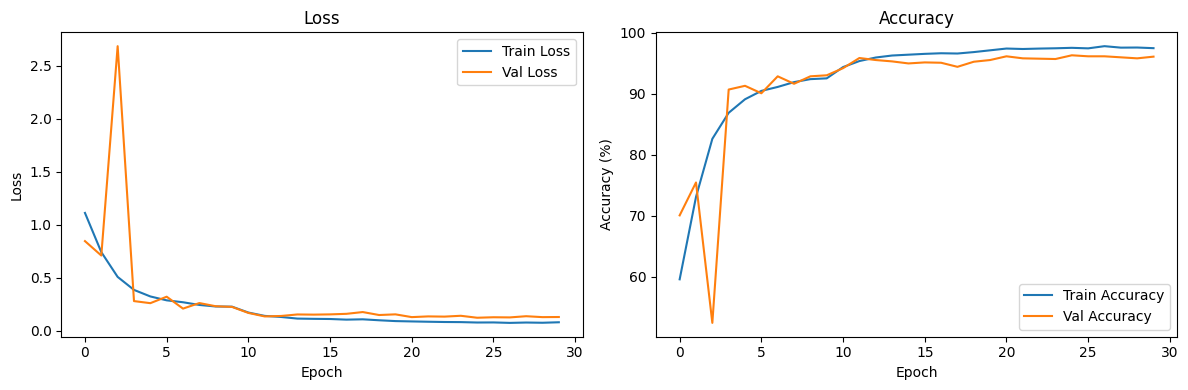

In [14]:
#LBL6
model.plot_training_history()

Пример тестирования модели на части набора данных:

In [15]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/14 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.9933:
	 balanced accuracy 0.9933:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [16]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/140 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9658:
	 balanced accuracy 0.9658:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [25]:
final_model = Model()
final_model.load('best_4_20_96')
d_test_tiny = HistologyTorchDataset(Dataset('test_tiny'), mode='test')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From (original): https://drive.google.com/uc?id=1sNa1g2OehbFTSD4WlmYiWLpZYa9Z74fh
From (redirected): https://drive.google.com/uc?id=1sNa1g2OehbFTSD4WlmYiWLpZYa9Z74fh&confirm=t&uuid=c8960694-9219-47c8-95bc-f85bbf139b0e
To: /content/best_4_20_96.npz
100%|██████████| 207M/207M [00:06<00:00, 32.9MB/s]


Model loaded
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/2 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9778:
	 balanced accuracy 0.9778:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"